## About

Date Created: 7/11/2024

This notebook contains code to generate a Bayesian Probabilistic model for 
coin flip, intended to be used as a project template by students in the ACE++
cohort - Summer 2024. 

For any questions, please reach out to the author, Muhammad Umair, at 
muhammad.umair@tufts.edu 

## Setup

In [72]:
import sys
import os
import numpy as np
import scipy.stats as st
import pymc as pm 
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any


In [73]:
# Define global variables here. 
SEED = 50 
OUTDIR = "./beta_bernoulli_coin_clip"

N_OBSERVATIONS = 300  # Number of students.


CORES = 1  # Number of cores to use for sampling. Should be 1 on most computers.
# Number of Markov chains to sample. 4 is a good starting point to ensure that
# the chains converge.
CHAINS = 4

In [74]:
# This ensures that the notebook is reproducible across runs. 
if SEED:
    np.random.seed(SEED)

# Create the output directory 
os.makedirs(OUTDIR,exist_ok=True)

### Utility Methods 

These are helper methods that may be useful for the project. 



In [75]:
def save_fig(
    fig: plt.Figure,
    fig_name: str,
    outdir: str,
    tight_layout: bool = True,
    fig_extension: str = "png",
    resolution: int = 300,
):
    """
    Save the figure that is most recently being used.

    Parameters
    ----------
    fig : Figure
        Figure object that needs to be saved.
    fig_name : str
        Name of the save file.
    outdir : str
        Output directory.
    tight_layout : bool, optional
       If True, sets tight layout for the output figure, by default True
    fig_extension : str, optional
       Extension using which to save the figure, by default "png"
    resolution : int, optional
        Resolution of the figure, by default 300
    """
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, f"{fig_name}.{fig_extension}")
    if tight_layout:
        fig.tight_layout()
    fig.savefig(path, format=fig_extension, dpi=resolution)


## Beta-Bernoulli Model of Coin Flips

The Beta-Bernoulli model is a hierarchical Bayesian model where the Beta distribution serves as the prior for the parameter of a Bernoulli distribution. Below is the mathematical formulation of the model along with detailed steps and assumptions.

### Assumptions

1. Beta Distribution Assumption:

- The parameter u(the probability of success in a Bernoulli trial) is modeled using a Beta distribution, which is a conjugate prior for the Bernoulli likelihood.
- The Beta distribution is parameterized by two shape parameters $a$ and $b$, which must be positive real numbers.
- The Beta distribution is defined on the interval \[0,1\],  aking it suitable for modeling probabilities.


2. Independence of Observations:

Each observed data point $x_i$ is assumed to be an independent and identically distributed (i.i.d.) sample from the Bernoulli distribution.


3. Bernoulli Distribution Assumption:

- The observed data is modeled using a Bernoulli distribution, parameterized by 
$u$ which represents the probability of observing a success (1) in a single trial.
- Each observation $x_i$ is a binary outcome (0 or 1).


### Model Definition

Prior:
The parameter 
$u$ of the Bernoulli distribution is drawn from a Beta distribution:


\begin{align*}
    u \sim \text{Beta}(a, b)
\end{align*}


where $a$ and $b$ are the shape parameters of the Beta distribution.

#### Likelihood:
Given the parameter $u$, the observed data $x$ (a sequence of 0s and 1s) follows a Bernoulli distribution:

\begin{align*}
x_i \sim \text{Bernoulli}(u) \quad \text{for} \quad i = 1, \ldots, N
\end{align*}
where N is the number of observations.

#### Joint Probability

The joint probability of the observed data and the parameter $u$ is:
u is:

\begin{align*}
P(\mathbf{x}, u \mid a, b) = P(\mathbf{x} \mid u) P(u \mid a, b)
\end{align*}

where:


$P(u \mid a, b)$ is the Beta prior: 

\begin{align*}
P(u \mid a, b) = \frac{u^{a-1} (1-u)^{b-1}}{B(a, b)}
\end{align*}

and 

$B(a,b)$ is the Beta function, defined as:


\begin{align*}
B(a, b) = \int_0^1 t^{a-1} (1-t)^{b-1} dt
\end{align*}

$P(x∣u)$ is the likelihood of the Bernoulli distribution:

\begin{align*}
P(\mathbf{x} \mid u) = \prod_{i=1}^{N} u^{x_i} (1-u)^{1-x_i}
\end{align*}


### Posterior Distribution

Using Bayes' theorem, the posterior distribution of $u$ given the observed data 
$x$ is:

\begin{align*}
P(u \mid \mathbf{x}, a, b) \propto P(\mathbf{x} \mid u) P(u \mid a, b)
\end{align*}

This represents the updated belief about the parameter 
u after observing the data.

### Observed Data

In this section, we generate the results of flipping a coin N times. 

Note that 
you should replace with any pre-processing code to load and convert your data 
into an array that should be used by your model. Your data should not be generated, 
but instead come from some data source. 

In [76]:
# Array of test scores
test_scores = np.random.randint(1, 101, size=N_OBSERVATIONS)


print(test_scores)

[49 97 12 34 95  5 71 71 23  6  3 96 72 69 79 36 93 92 27 91  7 21 44 32
 50 86 42 65  7 20  3 80 31 36 27 61 67 77 97 68  3 11 52  1 94 94 95  1
 12 31 27 72 52 29 25 92 47 63 14 72 37  1 59 44 65 20 59 46 84  2 62 10
 30 53 44 88 33 20 48 70 93  7 66 37 85 37 45 54 79  5 87 44 20 97 38 31
 63 45 44 36 28 51 59 29 32 16  6 53 56 57 48 69  5 19 43 18 91 73 47 12
 28 28 60  8 42 66 54 73 36  4 22 43 68 71 57 80 96 23  1 57 76 31 34 15
 91 23 47  7 63 31 37 58 96 10 60 65 59 81 56 27  5 44 66 38 14 36 15 57
  3 23 65 79 53 95 27 46 69 62 56 81 94 79 23 69 76 20 49 79  4 29 60  5
 42 28 55 72 78 22 93 52 22 42 79 78 36  7 60 63 13 43  1 46 65 73 97 43
 79 45  5 41 43 97 72 61 37 53 90 76 56 27 56 46 97 41 60 24 48 39 56 68
 58 93 63 70 93 51  2 48 36  4 65 47 13 77 97 54 22 79 20 46 81 34 84 55
 51 44 33 69 51 60 42 64 80 83 32 23 67  6 66 34 90 11 83 55 73 15 82 58
 80 93 34 88 42 87 57 85 93 20 84 37]


### Model Creation 

Now, based on our `formalism' i.e., our definition of the problem as a math 
problem, we create our bayesian model in pymc. 

In [85]:
# These values for the beta distribution generate a uniform looking distribution
# over the Beta distribution domain.
# Constants for the model
alpha = 2  # Shape parameter for the prior on M
beta = 2   # Shape parameter for the prior on M

k_0 = 5    # Baseline shape parameter for the Gamma distribution
theta = 10  # Scale parameter for the Gamma distribution

N_SAMPLES = 500 # Change this based on your computer - the more the better...

In [86]:
# PyMC Model
with pm.Model() as model:
    # Prior for the amount of misinformation M
    M = pm.Beta('M', alpha=alpha, beta=beta)
    
    # Likelihood of test scores S given M
    k = pm.Deterministic('k', k_0 * (1 - M))
    S = pm.Gamma('S', alpha=k, beta=1/theta, observed=test_scores)



In [79]:
#beta_bernoulli_coin_model = beta_bernoulli_model(
#    a=BETA_PRIOR_A, b=BETA_PRIOR_B, observed=observed_flips
#)

### Sampling

In [87]:
# From our model, we will now use Sequential Monte Carlo (SMC) sampler to
# generate a posterior distribution for the probability of being misinformed.
# NOTE: This might take a few minutes to run! 

with model:
    # Generating random data from the prior. This is will generate data from the
    # "prior predictive" distribution, which allows us to see how
    # our model qualitatively performs if we do not update our model with data.
    prior = pm.sample_prior_predictive(return_inferencedata=False)
    # The updating step
    # Here we call the simulator to generate samples from the posterior.
    # Multiple chains give more accuracy and allows for testing whether
    # the samples converge to their 'true values' (as we hope).
    # We also return_inferencedata for later use, and to suppress some warnings
    trace = pm.sample(cores = 1, chains = 4, draws = N_SAMPLES,
                                  return_inferencedata=False)
    
    # Generating random data from the updated (posterior) model.
    posterior = pm.sample_posterior_predictive(trace, return_inferencedata=False)



Sampling: [M, S]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [M]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 143 seconds.
Sampling: [S]


Output()

### Plotting Results 

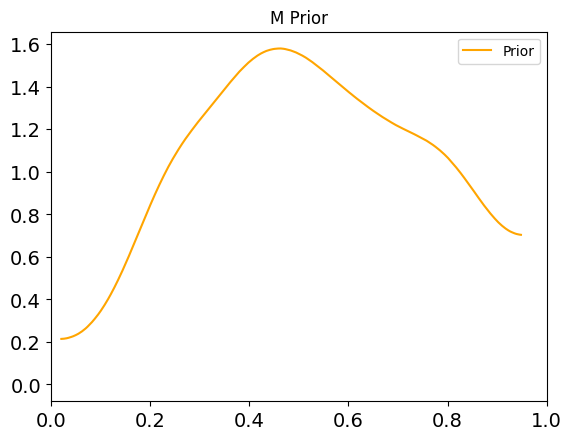

In [81]:

# Plot the prior and posterior for the u parameter 
fig,ax = plt.subplots()
az.plot_dist(prior["M"], color="orange", ax=ax, label="Prior")
plt.title("M Prior")
ax.set_xlim(0, 1)
plt.legend()
plt.savefig(f"{OUTDIR}/u.png") # this saves the output of the plot for including in reports
plt.show()


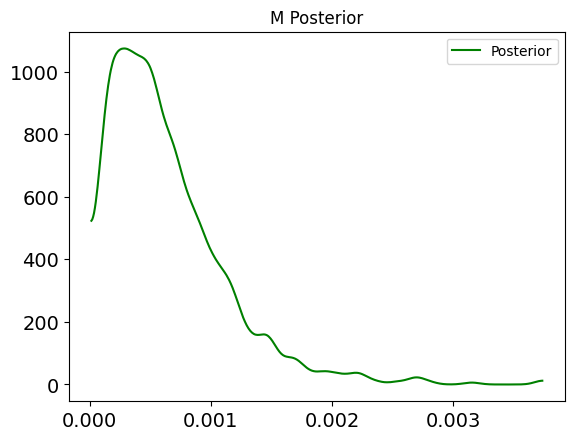

In [82]:
# Plot the prior and posterior for the u parameter 
fig,ax = plt.subplots()
az.plot_dist(trace["M"], color="green", ax=ax, label="Posterior")
plt.title("M Posterior")
plt.legend()
plt.savefig(f"{OUTDIR}/u.png") # this saves the output of the plot for including in reports
plt.show()


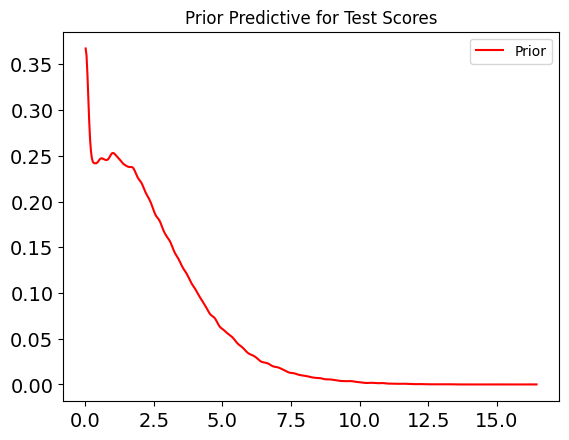

In [83]:
## Plotting the prior for coin flips based on u prior. 
fig, ax = plt.subplots()
az.plot_dist(prior["S"], color="red", ax=ax, label="Prior")
#az.plot_dist(posterior["S"], color="blue", ax=ax, label="Posterior")
plt.title("Prior Predictive for Test Scores")
#ax.set_xlim(0, 1)
plt.legend()
plt.savefig(f"{OUTDIR}/prior_predictive.png")
plt.show()



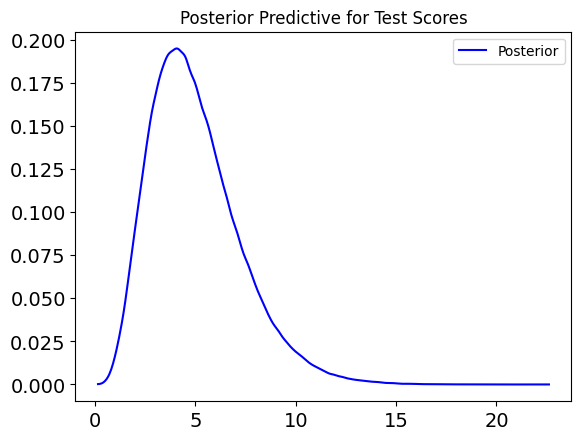

In [84]:
## Plotting the posterior for coin flips based on u posterior
fig, ax = plt.subplots()
az.plot_dist(posterior["S"], color="blue", ax=ax, label="Posterior")
plt.title("Posterior Predictive for Test Scores")
#ax.set_xlim(0, 1)
plt.legend()
plt.savefig(f"{OUTDIR}/posterior_predictive.png")
plt.show()

